In [57]:
import pandas as pd
from chromax import Simulator
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "jax"

from typing import Dict, Any, List
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Lambda

import tensorflow as tf


In [72]:
def create_fake_geneticmap(number_markers:int):
    """The genetic map represents the rules of the game. It assigns the truth value to each marker.

    :param number_markers: the total number of markers to include in this genetic map. must correspond to population shape
    :type number_markers: int 
    """
    # 'chr' will always be '1A' for every marker
    chr_array = ['1A'] * number_markers
    
    # 'yield': Create a marker_strength array with 1 float between -0.5 and +0.5 randomly
    # yield_array = np.random.poisson(np.random.randint(1,10), size=number_markers)
    poisson_values = np.random.poisson(np.random.randint(1, 10), size=number_markers)

    # Scale the Poisson values to the range [0, 1]
    scaled_poisson_values = poisson_values / np.max(poisson_values)

    # Stretch and shift the values to the range [-1, 1]
    yield_array = (scaled_poisson_values * 2) - 1
    
    # 'cM': create an array for number_markers length evenly sampled between 0 and 100
    cM_array = np.linspace(0, 100, num=number_markers)
    
    # Create the DataFrame with the auto-generated data
    df = pd.DataFrame({'CHR.PHYS': chr_array, 'Yield': yield_array, 'cM': cM_array*.01})
    
    return df

def create_fake_population(total_pops:int, number_individuals:int, number_markers:int, ploidy:int):
    """
        Creates a batch of populations. A populations is a group of individuals. An individual is composed of markers. Markers are 0 or 1

        Returns : binary array shape (total_pops, number_individuals, number_markers, ploidy)
    """
    # List of generation methods
    generation_methods = [
        lambda: np.random.randint(2, size=(number_individuals, number_markers, ploidy)),
        lambda: np.random.rand(number_individuals, number_markers, ploidy),
        lambda: np.random.standard_normal((number_individuals, number_markers, ploidy)),
        lambda: np.random.choice([0, 1], size=(number_individuals, number_markers, ploidy))
    ]
    
    populations = []
    for _ in range(total_pops):
        # Randomly select a generation method and generate the population
        gen_method = choice(generation_methods)
        population = gen_method()
        populations.append(population)
        
    # Combine all populations into a single numpy array
    combined_population = np.array(populations)
    return combined_population




def calculate_scores(population, marker_strength):
    """
    Calculates the additive score by matrix multipling the population (n,m) with the marker strengths (m,)
    """
    # Perform a dot product between the dosages and marker strength arrays
    dosages = np.sum(population,axis=2)
    scores = np.dot(dosages, marker_strength)
    return scores

def panmixia(selected_parents, total_offspring):
    """ Handles the random crossing for us ; heuristic!

    selected_parents ( n , m , d )
    
    """
    n, m, d = selected_parents.shape
    offspring_target = total_offspring
    offspring_list = []

    while len(offspring_list) < offspring_target:
        # Randomly pick two parents without replacement
        parents_indices = np.random.choice(n, size=2, replace=False)
        parent1, parent2 = selected_parents[parents_indices]

        # Simulate random recombination for each marker
        offspring = np.zeros((m, d), dtype=parent1.dtype)
        for i in range(m):
            # Randomly choose one allele from each parent for each marker
            for j in range(d):
                parent_allele = np.random.choice([parent1[i, j], parent2[i, j]])
                offspring[i, j] = parent_allele

        # Add the new offspring to the offspring list
        offspring_list.append(offspring)

    # Convert offspring list to a numpy array with shape (offspring_target, m, d)
    offspring_array = np.array(offspring_list)
    return offspring_array


def scores2parents(scores,K):
    """
    hint: use output from calculate_scores
    """
    # Specify the number of top values you want (K)
    K = 5

    # Get the indices that would sort the array
    sorted_indices = np.argsort(scores)

    # Take the last K indices of the sorted indices array
    top_k_indices = sorted_indices[-K:]

    # Since argsort returns indices in ascending order, reverse to get the top values
    top_k_indices = top_k_indices[::-1]

    print("Indices of top K values:", top_k_indices)
    print("Top K values:", scores[top_k_indices])

    return top_k_indices


def select_parents(policy, total_parents):
    """
        input: Policy from actor ( score or metric value for each individual )
        returns : index of parents to be included in random_crosses for next step of breeding program
    """
    values, indices = tf.math.top_k(policy, total_parents)
    return values,indices

def printshape(message , arr):
    print(f'{message} {arr.shape}')
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def score2hist(score, title='population score distribution'):
    #e.g. (3,50) array

    # Assuming 'data' is your (3,50) array
    data = score

    # Plot KDE for each row in the data
    for i in range(data.shape[0]):
        kde = gaussian_kde(data[i])
        dist_space = np.linspace(min(data[i]), max(data[i]), 100)
        plt.plot(dist_space, kde(dist_space), label=f'Distribution {i+1}')

    # Adding labels and legend
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.title(title)

    # Show plot
    plt.show()


# Example usage:
number_individuals = 50  # Replace with your actual number of individuals
number_markers = 100     # Replace with your actual number of markers
ploidy = 2              # Replace with your actual ploidy level
batch_size = 3
initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
genetic_map_df = create_fake_geneticmap(number_markers)
marker_strength = np.array(genetic_map_df['Yield'])
fraction_selection = 10

In [198]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Add
from tensorflow.keras import initializers
from tensorflow.keras.activations import softmax

def create_actor(num_individual, num_markers, ploidy, initializer='he_normal', use_skip_connection=False):

    #Layer normalization can help stabilize the training of deep networks by normalizing the inputs to each layer

    # Define the initializer
    init = getattr(initializers, initializer)()
    
    # Define the input layers
    population_input = Input(shape=(num_individual, num_markers, ploidy), name='population_input')
    phenotype_input = Input(shape=(num_individual, 1), name='phenotype_input')
    
    # Flatten the inputs
    flat_population = Flatten()(population_input)
    flat_phenotype = Flatten()(phenotype_input)
    
    # Combine inputs
    combined = concatenate([flat_population, flat_phenotype])
    
    # Define the hidden layers
    hidden1 = Dense(units=64, activation='relu', kernel_initializer=init)(combined)
    hidden2 = Dense(units=64, activation='relu', kernel_initializer=init)(hidden1)
    
    # Check if skip connection is to be used
    if use_skip_connection:
        # Transform phenotype input to match the shape of hidden2
        phenotype_transformed = Dense(units=64, activation='relu', kernel_initializer=init)(flat_phenotype)
        skip_connection = Add()([hidden2, phenotype_transformed])
        output = Dense(units=num_individual, activation='softmax', kernel_initializer=init)(skip_connection)
    else:
        output = Dense(units=num_individual, activation='softmax', kernel_initializer=init)(hidden2)
    
    # Create the model
    model = Model(inputs=[population_input, phenotype_input], outputs=output)
    
    return model


In [459]:
# Init

def init_program():
    number_individuals = 50  # Replace with your actual number of individuals
    number_markers = 100     # Replace with your actual number of markers
    ploidy = 2              # Replace with your actual ploidy level
    batch_size = 3
    initial_population = create_fake_population(batch_size, number_individuals, number_markers, ploidy)
    #printshape('first pop shape' , initial_population)
    genetic_map_df = create_fake_geneticmap(number_markers)
    marker_strength = np.array(genetic_map_df['Yield'])
    fraction_selection = 10

    #score init pop
    initial_score = np.array([calculate_scores(x,marker_strength) for x in initial_population])
    #printshape('first score list shape' , initial_score)

    #score2hist(initial_score)

    return initial_population, initial_score, genetic_map_df, marker_strength


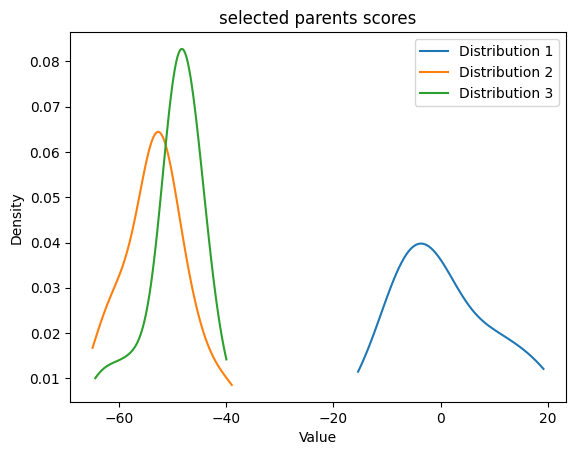

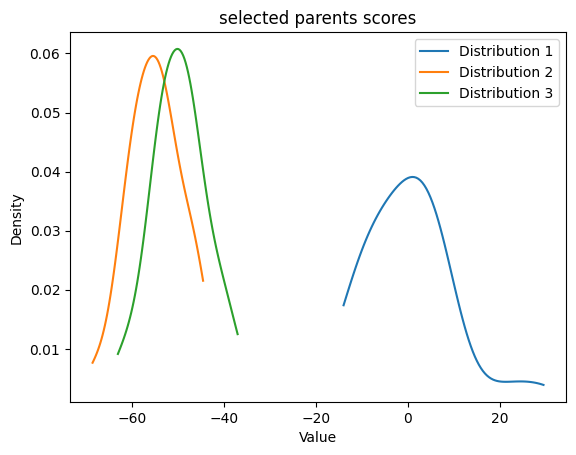

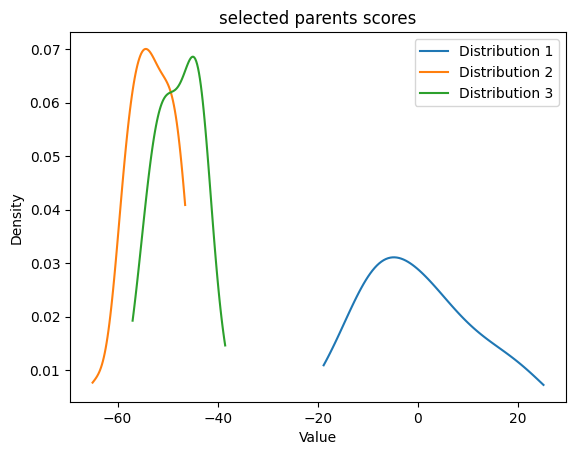

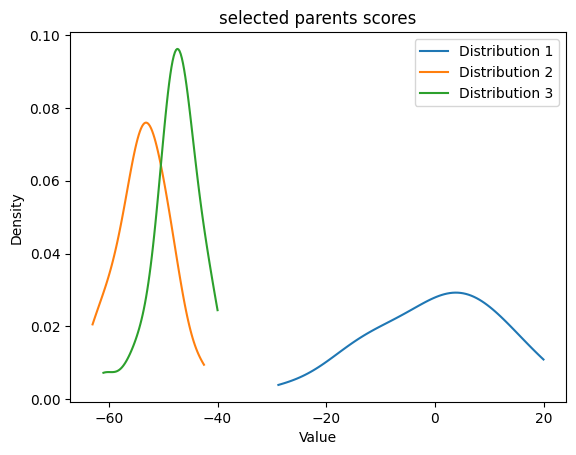

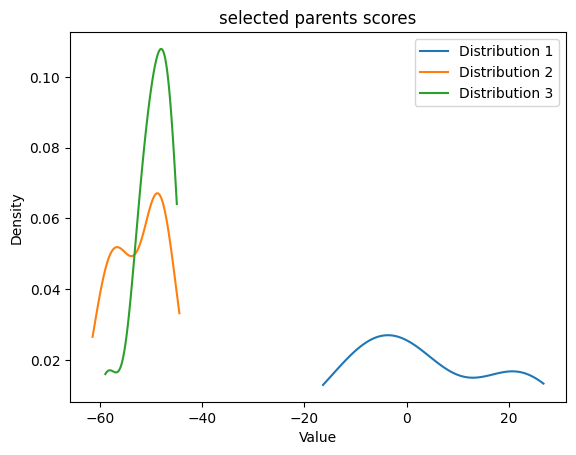

In [460]:
#random selection baseline

initial_population, initial_score, genetic_map_df, marker_strength = init_program()

current_population = initial_population
current_score = initial_score

for _ in range(5):
    #select random half of individuals in each pop
    selected_parents = current_population[:,:25,:,:]
    selected_parents_score = np.array([calculate_scores(x, marker_strength) for x in selected_parents])
    new_pop = np.array([panmixia(x, total_offspring=initial_population.shape[1]) for x in selected_parents])
    new_score = np.array([calculate_scores(x, marker_strength) for x in new_pop])
    
    current_population = new_pop
    current_score = new_score
    score2hist(selected_parents_score, title='selected parents scores')

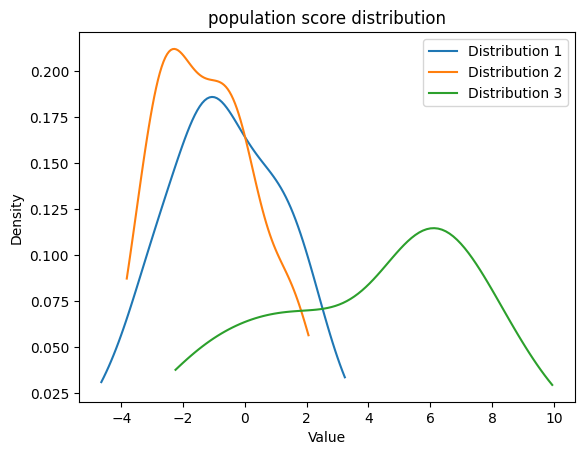

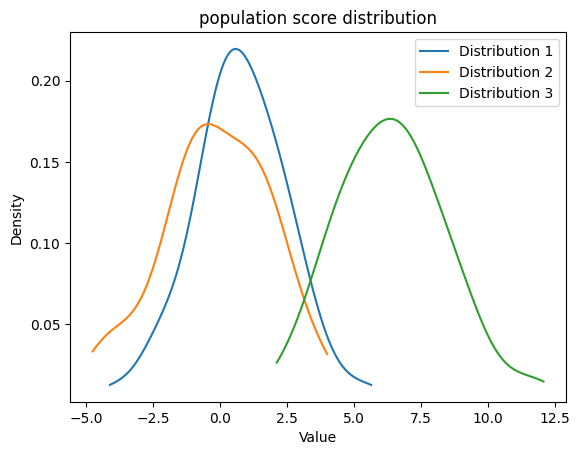

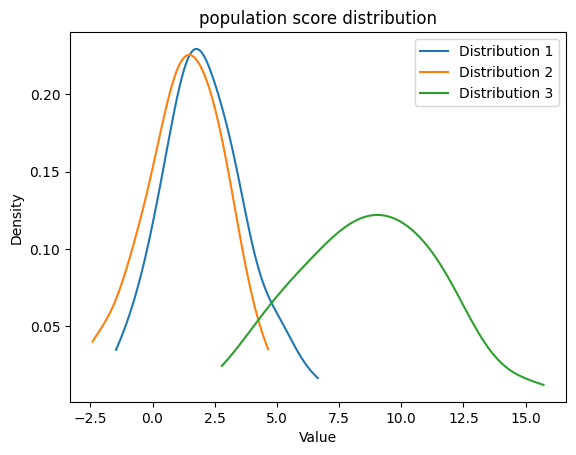

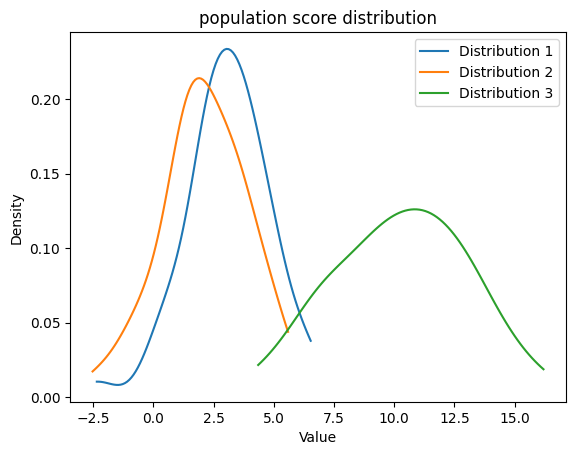

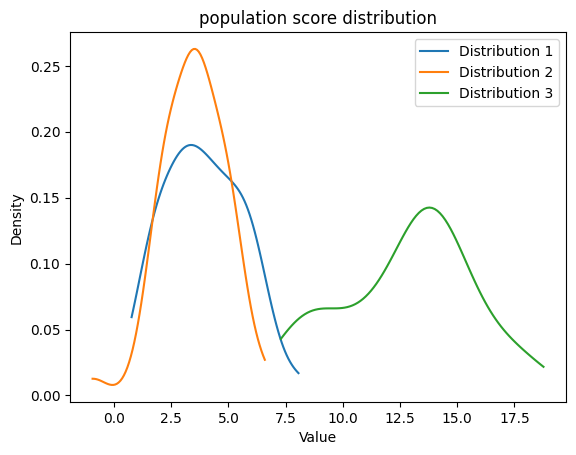

In [461]:
#truncation selection baseline

initial_population, initial_score, genetic_map_df, marker_strength = init_program()

current_population = initial_population
current_score = initial_score

frames = []
for _ in range(5):
    #select top half of individuals in each pop
    truncation = [select_parents(x,int(initial_population.shape[1]/2)) for x in current_score]
    parent_index = [x[1] for x in truncation]
    parent_metric = [x[0] for x in truncation]
    parent_pop = np.array([x[y] for x,y in zip(current_population, parent_index)])    
    new_pop = np.array([panmixia(x, total_offspring=initial_population.shape[1]) for x in parent_pop])
    new_score = np.array([calculate_scores(x, marker_strength) for x in new_pop])
    
    current_population = new_pop
    current_score = new_score
    score2hist(current_score)
    frames.append(current_score)

frames = np.array(frames)

In [462]:
frames.shape

(5, 3, 50)

MovieWriter imagemagick unavailable; using Pillow instead.


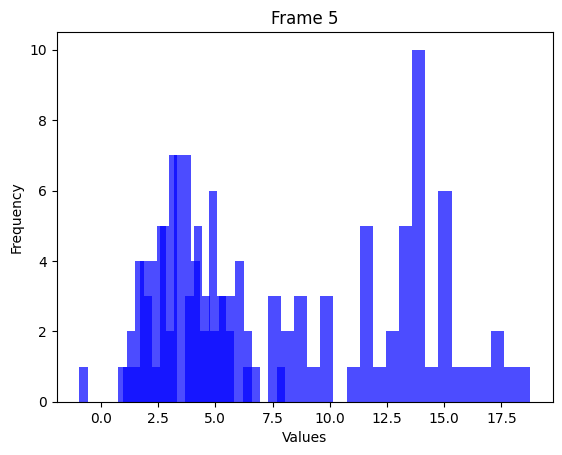

In [463]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio

# Suppose `data` is your 3D NumPy array: (frames, population, values)
# For the sake of example, let's create a random 3D array
data = frames

# Define the number of bins for the histogram
nbins = 20

# Create a figure and a histogram
fig, ax = plt.subplots()

# Initialize the histogram with the data from the first frame
hist_data, bins, patches = plt.hist(data[0].flatten(), bins=nbins, alpha=0.7, color='blue')

# Animation update function
def update_hist(frame_number):
    plt.cla()  # Clear the current axes
    [plt.hist(x.flatten(), bins=nbins, alpha=0.7, color='blue') for x in data[frame_number]]
    plt.title(f'Frame {frame_number+1}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')

# Create the animation
ani = animation.FuncAnimation(fig, update_hist, frames=range(data.shape[0]), repeat=False)

# Save the animation as a GIF
ani.save('histograms.gif', writer='imagemagick', fps=2)

plt.show()  # Show the plot


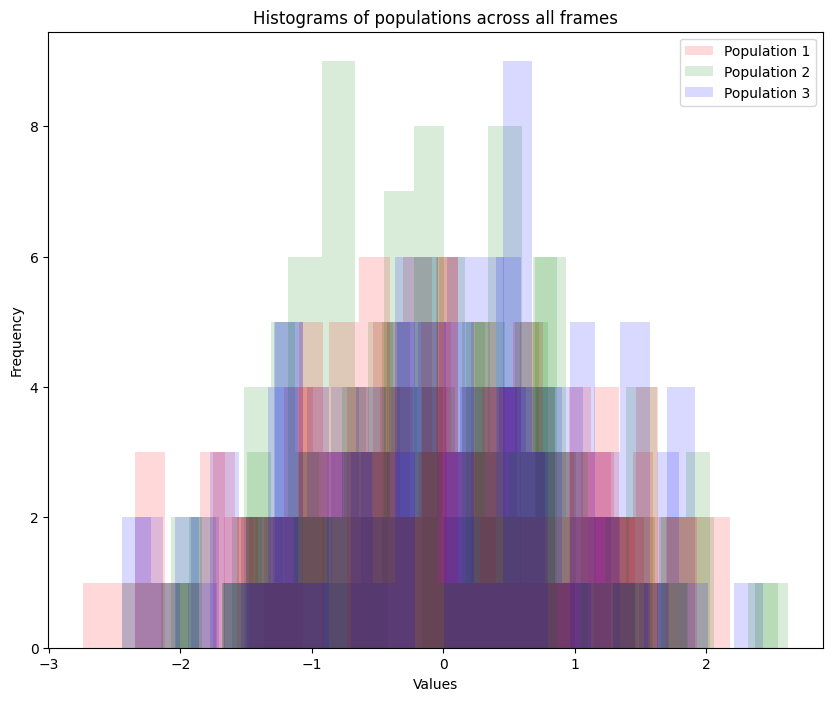

In [464]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `data` is your 3D NumPy array: (frames, population, values)
# Replace this with your actual data array
data = np.random.randn(5, 3, 50)  # Example data

# Define the number of bins for the histograms
nbins = 20

# Set up the plot
plt.figure(figsize=(10, 8))

# Create a color list if you want specific colors for each population
colors = ['red', 'green', 'blue']

# Loop over each frame
for frame_number in range(data.shape[0]):
    # Plot histogram for each population
    for population_idx in range(data.shape[1]):
        plt.hist(data[frame_number, population_idx, :], bins=nbins, alpha=0.15, color=colors[population_idx], label=f'Population {population_idx+1}' if frame_number == 0 else "")

# Add legend, titles and labels
plt.legend()
plt.title('Histograms of populations across all frames')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()


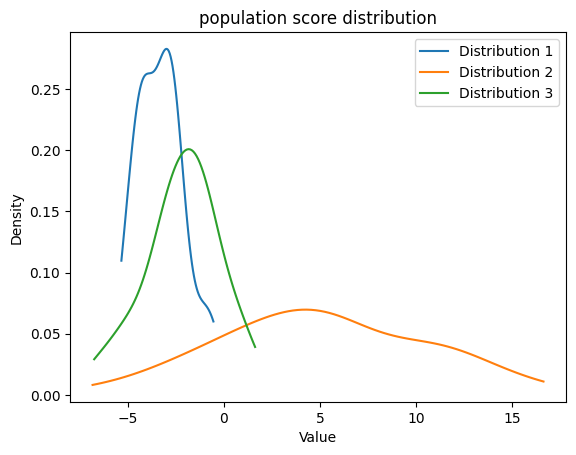

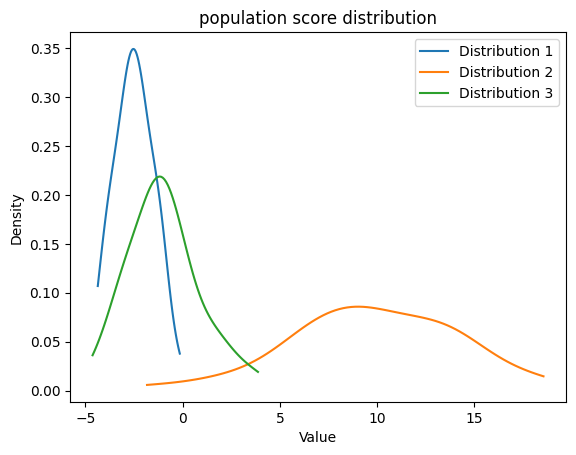

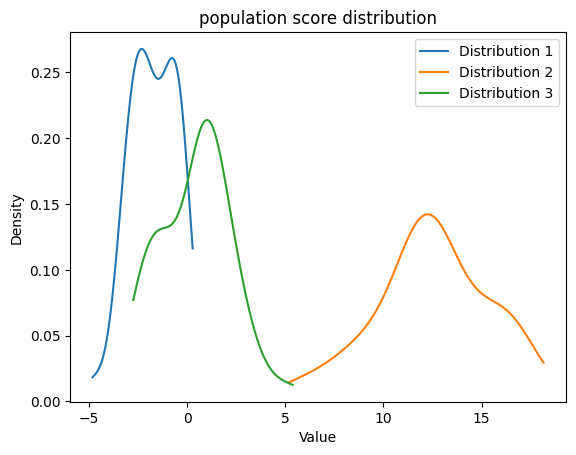

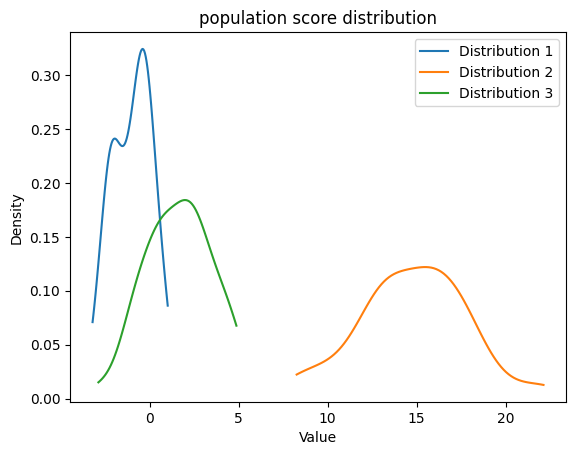

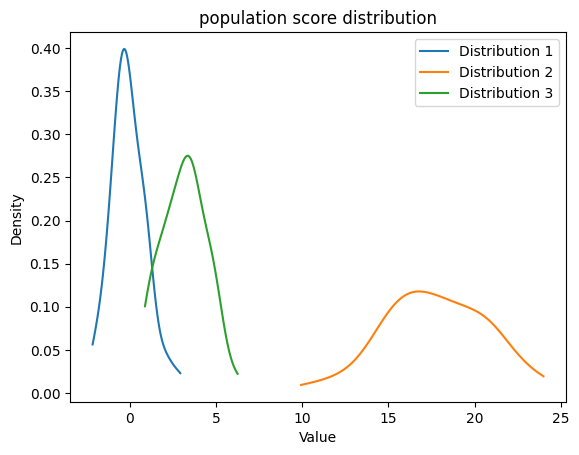

In [465]:
#truncation selection baseline

initial_population, initial_score, genetic_map_df, marker_strength = init_program()

current_population = initial_population
current_score = initial_score

frames = []
for _ in range(5):
    #select top half of individuals in each pop
    truncation = [select_parents(x,int(initial_population.shape[1]/2)) for x in current_score]
    parent_index = [x[1] for x in truncation]
    parent_metric = [x[0] for x in truncation]
    parent_pop = np.array([x[y] for x,y in zip(current_population, parent_index)])    
    new_pop = np.array([panmixia(x, total_offspring=initial_population.shape[1]) for x in parent_pop])
    new_score = np.array([calculate_scores(x, marker_strength) for x in new_pop])
    
    current_population = new_pop
    current_score = new_score
    score2hist(current_score)
    frames.append(current_score)

frames = np.array(frames)

In [466]:
agent1 = create_actor_model(number_individuals, number_markers, initializer='he_normal', use_skip_connection=False)
agent2 = create_actor_model(number_individuals, number_markers, initializer='he_normal', use_skip_connection=True)

initial_population, initial_score, genetic_map_df, marker_strength = init_program()

current_population = initial_population
current_score = initial_score

TypeError: create_actor_model() missing 1 required positional argument: 'ploidy'

first pop shape (3, 50, 100, 2)
first score list shape (3, 50)


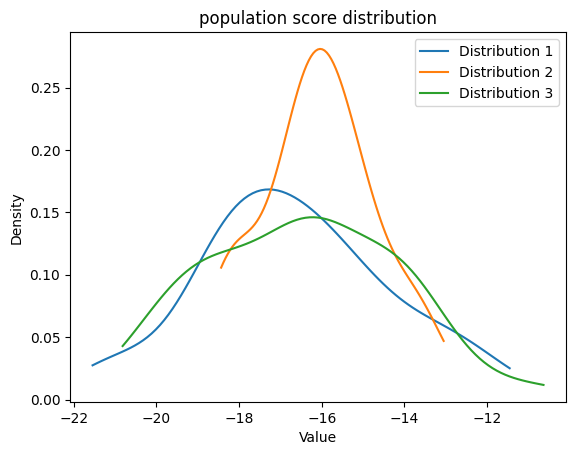

/home/glect/breeder_agent/agent_env/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
def panmixia(selected_parents, total_offspring):
    """ Handles the random crossing for us ; heuristic!

    selected_parents ( n , m , d )
    
    """
    n, m, d = selected_parents.shape
    offspring_target = total_offspring
    offspring_list = []

    while len(offspring_list) < offspring_target:
        # Randomly pick two parents without replacement
        parents_indices = np.random.choice(n, size=2, replace=False)
        parent1, parent2 = selected_parents[parents_indices]

        # Simulate random recombination for each marker
        offspring = np.zeros((m, d), dtype=parent1.dtype)
        for i in range(m):
            # Randomly choose one allele from each parent for each marker
            for j in range(d):
                parent_allele = np.random.choice([parent1[i, j], parent2[i, j]])
                offspring[i, j] = parent_allele

        # Add the new offspring to the offspring list
        offspring_list.append(offspring)

    # Convert offspring list to a numpy array with shape (offspring_target, m, d)
    offspring_array = np.array(offspring_list)
    return offspring_array

def policy2score(policy):
    """collect one result of a sample from from the stochastic policy"""
    sampled_indexes = [list(set(np.random.choice(np.arange(x.shape[0]), size=25, replace=True, p=x.numpy()))) for x in policy]
    parent_pops = [p[s] for p,s in zip(current_population, sampled_indexes)]
    new_pops = np.array([panmixia(x, total_offspring=current_population.shape[1]) for x in parent_pops])
    new_scores = np.array([calculate_scores(x,marker_strength) for x in new_pops])
    return new_pops, new_scores


def calculate_scores(population, marker_strength):
    """
    Calculates the additive score by matrix multipling the population (n,m) with the marker strengths (m,)
    """
    # Perform a dot product between the dosages and marker strength arrays
    dosages = np.sum(population,axis=2)
    scores = np.dot(dosages, marker_strength)
    return scores

# INIT
initial_population, initial_score, genetic_map_df, marker_strength = init_program()

current_population = initial_population
current_score = initial_score

agent = create_actor(initial_population.shape[1], initial_population.shape[2], initializer='glorot_uniform', use_skip_connection=False, ploidy = ploidy)

# STEP
#get a probability of selecting each input individual from the current populuation
agent_policy = agent([current_population, current_score])

geno, pheno = policy2score(agent_policy)

true_scores = [x.mean() for x in pheno]
past_scores = [x.mean() for x in current_score]

rewards = [(t-p) for t,p in zip(true_scores,past_scores)] # loss to maximize by network



In [ ]:
import tensorflow as tf





def tf_calculate_scores(population, marker_strength):
    """Calculates the additive score by multiplying the population with the marker strengths.

    Args:
        population: A 3D tensor (batch, num_individuals, num_markers)
        marker_strength: A 1D tensor containing the marker strengths

    Returns:
        A 2D tensor containing the scores for each individual in the population
    """
    # Sum across the ploidy dimension and then perform a dot product with marker_strength
    dosages = tf.reduce_sum(population, axis=2)
    scores = tf.linalg.matvec(dosages, marker_strength)
    return scores


def tf_policy2score(policy, current_population, marker_strength, selection_count=25):
    """Collect one result of a sample from the stochastic policy.

    Args:
        policy: A 2D tensor with shape (batch, num_individuals) representing the policy probabilities
        current_population: A 4D tensor with shape (batch, num_individuals, num_markers, ploidy)
        marker_strength: A 1D tensor containing the marker strengths
        selection_count: The number of parents to select based on the policy

    Returns:
        A tuple of new populations and new scores
    """
    # Sample from the policy
    sampled_indices = tf.random.categorical(tf.math.log(policy), selection_count)
    
    # Gather the selected parents
    parent_pops = tf.gather(current_population, sampled_indices, batch_dims=1)
    
    # Perform panmixia to generate new populations
    new_pops = tf.vectorized_map(lambda x: tf_panmixia(x, total_offspring=current_population.shape[1]), parent_pops)
    
    # Calculate new scores using TensorFlow operations
    new_scores = tf.vectorized_map(lambda x: tf_calculate_scores(x, marker_strength), new_pops)
    
    return new_pops, new_scores


In [ ]:
def tf_panmixia(selected_parents, total_offspring):
    """Handles the random crossing for us; heuristic!

    Args:
        selected_parents: A 3D tensor (batch, num_individuals, ploidy)
        total_offspring: The total number of offspring to produce

    Returns:
        A 3D tensor representing the offspring
    """
    num_individuals = tf.shape(selected_parents)[1]
    num_markers = selected_parents.shape[2]  # Assuming num_markers is the second dimension
    ploidy = selected_parents.shape[3]

    # Randomly pick two parents for each offspring
    parents_indices = tf.random.uniform((total_offspring, 2), maxval=num_individuals, dtype=tf.int32)

    # Gather the parents based on the random indices
    parents = tf.gather(selected_parents, parents_indices, batch_dims=1)

    # Create a random mask to select alleles from the first or second parent
    random_mask = tf.random.uniform(tf.shape(parents), maxval=2, dtype=tf.int32)
    random_mask = tf.equal(random_mask, 0)

    # Use the random mask to select alleles from the two parents
    offspring = tf.where(random_mask, parents[..., 0], parents[..., 1])

    return offspring


In [473]:
import tensorflow as tf

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Convert marker_strength to a tensor
marker_strength = tf.convert_to_tensor(marker_strength, dtype=tf.float32)

# Assuming init_program initializes the environment and returns the initial population, scores, etc.
initial_population, initial_score, genetic_map_df, marker_strength = init_program()

# Convert initial population and scores to tensors
current_population = tf.convert_to_tensor(initial_population, dtype=tf.float32)
current_score = tf.convert_to_tensor(initial_score, dtype=tf.float32)

# Create the agent model
agent = create_actor(current_population.shape[1], current_population.shape[2], initializer='glorot_uniform', use_skip_connection=False, ploidy=ploidy)

@tf.function
def train_step(current_population, current_score):
    # with tf.GradientTape() as tape:
    # Get the policy output from the agent
    agent_policy = agent([current_population, current_score], training=True)

    # Sample from the policy
    sampled_indices = tf.random.categorical(tf.math.log(agent_policy), int(current_population.shape[1]/2))
    
    # Gather the selected parents
    parent_pops = tf.gather(current_population, sampled_indices, batch_dims=1)

    return parent_pops

    # parents_indices = tf.random.uniform(int(current_population.shape[1]/2), 2, maxval=current_population.shape[1], dtype=tf.int32)
    # # Perform panmixia to generate new populations
    print(f'TESTING {parent_pops}')        
    # # Calculate new scores using TensorFlow operations
    # new_scores = tf.vectorized_map(lambda x: tf_calculate_scores(x, marker_strength), new_pops)
    # # Calculate the mean score for the new population
    # true_scores = tf.reduce_mean(new_scores, axis=[1, 2])
        # past_scores = tf.reduce_mean(current_score, axis=[1, 2])
        
        # # Compute the rewards as the difference in scores
        # rewards = true_scores - past_scores
        
        # # Define the loss function to be negative rewards
        # loss_value = -tf.reduce_mean(rewards)
    
    # # Compute the gradients of the loss function
    # grads = tape.gradient(loss_value, agent.trainable_variables)
    
    # # Apply the gradients to the model's parameters
    # optimizer.apply_gradients(zip(grads, agent.trainable_variables))
    
    # return new_pops, new_scores, loss_value

# Training loop
num_epochs = 3  # Define the number of epochs to train for
for epoch in range(num_epochs):
    single_step = train_step(current_population, current_score)

/home/glect/breeder_agent/agent_env/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [482]:
single_step.shape

TensorShape([3, 25, 100, 2])

In [478]:
generate_offspring(single_step).shape

TensorShape([50, 25, 2, 25])

In [481]:
current_population.shape

TensorShape([3, 50, 100, 2])

In [483]:

def generate_offspring(parent_pops, num_matings=50):
    # Initialize list to hold offspring for each batch
    new_population_batches = []
    
    # Iterate over each batch
    for batch in range(parent_pops.shape[0]):
        # Initialize list to hold offspring for the current batch
        new_population = []
        
        for _ in range(num_matings):
            # Randomly select two parents for each mating
            parent_indices = tf.random.uniform([2], minval=0, maxval=parent_pops.shape[1], dtype=tf.int32)
            parents = tf.gather(parent_pops[batch], parent_indices)
            
            # For each marker, randomly sample one ploidy value from each parent's markers
            ploidy_indices = tf.random.uniform([parent_pops.shape[2], 2], minval=0, maxval=2, dtype=tf.int32)
            offspring_markers = tf.stack([
                tf.gather(parents[i, :, :], ploidy_indices[:, i], axis=1) for i in range(2)
            ], axis=2)
            
            # Append the offspring to the new population for the current batch
            new_population.append(offspring_markers)
        
        # Convert the list of offspring to a tensor and append to the batch list
        new_population_tensor = tf.stack(new_population)
        new_population_batches.append(new_population_tensor)
    
    # Convert the list of batch offspring to a tensor
    new_population_batches_tensor = tf.stack(new_population_batches)
    return new_population_batches_tensor

In [485]:
new_population = generate_offspring(single_step)
